Code written by Shashank Jerri(AI21MTECH11003) and Aman Ladkat(AI21MTECH14011)

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.utils import np_utils
#from tensorflow.keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [11]:
Ravdess = "/content/drive/MyDrive/DL Project/Audio_Song_Actors_01-24/"
Savee = "/content/drive/MyDrive/DL Project/ALL/"
Tess = "/content/drive/MyDrive/DL Project/TESS Toronto emotional speech set data/"

In [12]:
ravdess_dir_ls = os.listdir(Ravdess)

file_emotion = []
file_path = []
filenames = []
for dir in ravdess_dir_ls:
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        filenames.append(file)
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
# filename_df = pd.DataFrame(filenames, columns=['FileName'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,neutral,/content/drive/MyDrive/DL Project/Audio_Song_A...
1,neutral,/content/drive/MyDrive/DL Project/Audio_Song_A...
2,neutral,/content/drive/MyDrive/DL Project/Audio_Song_A...
3,calm,/content/drive/MyDrive/DL Project/Audio_Song_A...
4,neutral,/content/drive/MyDrive/DL Project/Audio_Song_A...


In [13]:
tess_dir_ls = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_dir_ls:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

,Emotions,Path
0,sad,/content/drive/MyDrive/DL Project/TESS Toronto...
1,sad,/content/drive/MyDrive/DL Project/TESS Toronto...
2,sad,/content/drive/MyDrive/DL Project/TESS Toronto...
3,sad,/content/drive/MyDrive/DL Project/TESS Toronto...
4,sad,/content/drive/MyDrive/DL Project/TESS Toronto...


In [14]:
savee_dir_ls = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_dir_ls:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

,Emotions,Path
0,angry,/content/drive/MyDrive/DL Project/ALL/DC_a01.wav
1,angry,/content/drive/MyDrive/DL Project/ALL/DC_a02.wav
2,angry,/content/drive/MyDrive/DL Project/ALL/DC_a13.wav
3,angry,/content/drive/MyDrive/DL Project/ALL/DC_a07.wav
4,angry,/content/drive/MyDrive/DL Project/ALL/DC_a09.wav


In [15]:
data_path = pd.concat([Ravdess_df, Tess_df, Savee_df], axis = 0)
data_path.Emotions.replace({'neutral':1, 'calm':2, 'happy':3, 'sad':4, 'angry':5, 'fear':6, 'disgust':7, 'surprise':8}, inplace=True)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,1,/content/drive/MyDrive/DL Project/Audio_Song_A...
1,1,/content/drive/MyDrive/DL Project/Audio_Song_A...
2,1,/content/drive/MyDrive/DL Project/Audio_Song_A...
3,2,/content/drive/MyDrive/DL Project/Audio_Song_A...
4,1,/content/drive/MyDrive/DL Project/Audio_Song_A...


In [16]:
!pip install transformers
# !pip install tensorboardx

     |████████████████████████████████| 4.0 MB 5.1 MB/s 
     |████████████████████████████████| 6.6 MB 45.8 MB/s 
     |████████████████████████████████| 596 kB 63.0 MB/s 
     |████████████████████████████████| 77 kB 7.9 MB/s 
     |████████████████████████████████| 880 kB 40.9 MB/s 
     |████████████████████████████████| 96 kB 7.7 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.50-py3-none-any.whl size=895166 sha256=3617d704214623cb8800e96b33fc21fb551ae17982c79d9dcaa9597a041bc03a
  Stored in directory: /root/.cache/pip/wheels/d9/72/54/519f0d5143cc6c73fa3297509123c86fc8586a7fdea8d25311
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into a

In [17]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.backend_bases import RendererBase
from scipy import signal
from scipy.io import wavfile
import os
from PIL import Image
from scipy.fftpack import fft
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
import torchvision.datasets as datasets
import torchvision.transforms as transforms


In [18]:
def audio2spectrogram(filepath):
    #fig = plt.figure(figsize=(5,5))
    samplerate, test_sound  = wavfile.read(filepath,mmap=True)
    #print('samplerate',samplerate)
    _, spectrogram = log_specgram(test_sound, samplerate)
    #print(spectrogram.shape)
    #print(type(spectrogram))
    #plt.imshow(spectrogram.T, aspect='auto', origin='lower')
    return spectrogram
    
def audio2wave(filepath):
    fig = plt.figure(figsize=(5,5))
    samplerate, test_sound  = wavfile.read(filepath,mmap=True)
    plt.plot(test_sound)

In [19]:
def log_specgram(audio, sample_rate, window_size=40,
                 step_size=20, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    #print('noverlap',noverlap)
    #print('nperseg',nperseg)
    freqs, _, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, np.log(spec.T.astype(np.float32) + eps)

In [20]:
N_CHANNELS = 3
def get_3d_spec(Sxx_in, moments=None):
    if moments is not None:
        (base_mean, base_std, delta_mean, delta_std,
             delta2_mean, delta2_std) = moments
    else:
        base_mean, delta_mean, delta2_mean = (0, 0, 0)
        base_std, delta_std, delta2_std = (1, 1, 1)
    h, w = Sxx_in.shape
    right1 = np.concatenate([Sxx_in[:, 0].reshape((h, -1)), Sxx_in], axis=1)[:, :-1]
    delta = (Sxx_in - right1)[:, 1:]
    delta_pad = delta[:, 0].reshape((h, -1))
    delta = np.concatenate([delta_pad, delta], axis=1)
    right2 = np.concatenate([delta[:, 0].reshape((h, -1)), delta], axis=1)[:, :-1]
    delta2 = (delta - right2)[:, 1:]
    delta2_pad = delta2[:, 0].reshape((h, -1))
    delta2 = np.concatenate([delta2_pad, delta2], axis=1)
    base = (Sxx_in - base_mean) / base_std
    delta = (delta - delta_mean) / delta_std
    delta2 = (delta2 - delta2_mean) / delta2_std
    stacked = [arr.reshape((h, w, 1)) for arr in (base, delta, delta2)]
    return np.concatenate(stacked, axis=2)

In [21]:
def file_search(dirname, ret, list_avoid_dir=[]):
    filenames = os.listdir(dirname)
    
    for filename in filenames:
        full_filename = os.path.join(dirname, filename)

        if os.path.isdir(full_filename) :
            if full_filename.split('/')[-1] in list_avoid_dir:
                continue
            else:
                file_search(full_filename, ret, list_avoid_dir)
            
        else:
            ret.append( full_filename ) 

In [22]:
import pandas as pd
df=data_path["Emotions"]

In [23]:
list_files = []

for path in data_path['Path']:
  list_files.append(path)


In [24]:
print(len(list_files))

3692


In [25]:
no_rows=len(list_files)
index=0
sprectrogram_shape=[]
docs = []
bookmark=0
extraLabel=0
for everyFile in list_files:
  try:
      if(everyFile.split('/')[-1].endswith('.wav')):
        # filename=everyFile.split('/')[-1].strip('.wav')
        lable=data_path[data_path['Path']==everyFile]['Emotions'].values[0]
        print('label',lable)
        if(lable!=-1):
          #sprectrogram_shape.append(audio2spectrogram(everyFile))
          spector=audio2spectrogram(everyFile)
          spector=get_3d_spec(spector)
          npimg = np.transpose(spector,(2,0,1))
          input_tensor=torch.tensor(npimg)
          input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
          #X, sample_rate = librosa.load(everyFile, res_type='kaiser_fast',sr=22050*2)
          #sample_rate = np.array(sample_rate)
          #mfccs = np.mean(librosa.feature.mfcc(y=X,sr=sample_rate,n_mfcc=13),axis=0)
          #feature = mfccs
          doc = {
            'fileName':everyFile.split('/')[-1].strip('.wav'),
            #'feature_mfcc':feature,
            'sprectrome':input_batch,
            'label':lable -1
                  }


          # print(doc)
          docs.append(doc)
          index+=1
          print('index',index)
        else:
          extraLabel=extraLabel+1
          print('extraLabel',extraLabel)
  except:
      pass

label 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  This is separate from the ipykernel package so we can avoid doing imports until


label 1
label 1
label 2
label 1
label 2
label 2
index 1
label 2
label 2
label 3
index 2
label 2
index 3
label 2
label 2
label 3
index 4
label 4
index 5
label 3
index 6
label 3
index 7
label 4
label 3
index 8
label 3
index 9
label 3
index 10
label 3
index 11
label 4
index 12
label 4
label 5
index 13
label 4
index 14
label 5
index 15
label 5
index 16
label 5
index 17
label 5
index 18
label 5
label 4
label 4
label 4
label 6
label 6
label 5
index 19
label 6
label 6
label 6
index 20
label 5
index 21
label 6
index 22
label 6
label 6
label 2
label 2
index 23
label 1
index 24
label 2
label 2
label 1
index 25
label 2
label 1
label 2
label 1
label 2
label 2
label 4
index 26
label 4
label 3
label 3
label 4
label 3
label 3
label 3
label 4
label 3
label 3
label 4
label 3
label 5
index 27
label 5
index 28
label 4
index 29
label 5
index 30
label 4
label 5
index 31
label 5
index 32
label 5
index 33
label 4
index 34
label 5
index 35
label 5
index 36
label 6
index 37
label 6
index 38
label 6
index 39
la

/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 1920 is greater than input length  = 2, using nperseg = 2
  .format(nperseg, input_length))


Streaming output truncated to the last 5000 lines.
label 4
index 718
label 4
index 719
label 4
index 720
label 4
index 721
label 4
index 722
label 4
index 723
label 4
index 724
label 4
index 725
label 4
index 726
label 4
index 727
label 4
index 728
label 4
index 729
label 4
index 730
label 4
index 731
label 4
index 732
label 4
index 733
label 4
index 734
label 4
index 735
label 4
index 736
label 4
index 737
label 4
index 738
label 1
index 739
label 1
index 740
label 1
index 741
label 1
index 742
label 1
index 743
label 1
index 744
label 1
index 745
label 1
index 746
label 1
index 747
label 1
index 748
label 1
index 749
label 1
index 750
label 1
index 751
label 1
index 752
label 1
index 753
label 1
index 754
label 1
index 755
label 1
index 756
label 1
index 757
label 1
index 758
label 1
index 759
label 1
index 760
label 1
index 761
label 1
index 762
label 1
index 763
label 1
index 764
label 1
index 765
label 1
index 766
label 1
index 767
label 1
index 768
label 1
index 769
label 1
index

In [26]:
import torch
import torch.nn as nn
# #from .utils import load_state_dict_from_url
# from torch.hub import load_state_dict_from_url

# __all__ = ['AlexNet', 'alexnet']


# model_urls = {
#     'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
# }


# class AlexNet(nn.Module):
#     def __init__(self, num_classes=8):
#         super(AlexNet, self).__init__()
#         self.num_classes=num_classes
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(96, 256, kernel_size=5, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(256, 384, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(384, 384, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(384, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#         )
#         # self.avgpool = nn.AdaptiveAvgPool2d((12, 12))
#         self.classifier = nn.Sequential(
#             nn.Dropout(),
#             nn.Linear(9216, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Linear(4096, 1000)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         print(x.shape)
#         # print('features',x.shape)
        
#         # x = self.avgpool(x)
#         # print('avgpool',x.shape)
#         x = torch.flatten(x, 1)
#         print('flatten',x.shape)
#         x = self.classifier(x)
#         return x
# def alexnet(pretrained=False, progress=True, **kwargs):
#     model = AlexNet(**kwargs)
#     if pretrained:
#         state_dict = load_state_dict_from_url(model_urls['alexnet'],
#                                               progress=progress)
#         model.load_state_dict(state_dict)
#     return model

In [27]:
# class ModifiedAlexNet(nn.Module):
#     def __init__(self, num_classes=8):
#         super(ModifiedAlexNet, self).__init__()
#         self.num_classes=num_classes
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(64, 192, kernel_size=5, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(192, 384, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(384, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#         )
#         self.classifier = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(256, num_classes),
#         )
#         self.softmax = nn.Softmax(dim=1)

#     def forward(self, x):
#         x = self.features(x)
#         #print('features',x.shape)
#         x=torch.flatten(x, start_dim=2)#a1,a2,a3......al{a of dim c} 
#         x=torch.sum(x, dim=2)#a1*alpha1+a2*alpha2+.......+al*alphal
#         #print(x.shape)
#         x=self.classifier(x)
#         #print('classifier',x)
#         #x=self.softmax(x)
#         #print('softmax',x)
#         #x = self.avgpool(x)
#         #print('avgpool',x.shape)
#         #x = torch.flatten(x, 1)
#         #print('flatten',x.shape)
#         #x = self.classifier(x)
#         return x
   
# def modifiedAlexNet(pretrained=False, progress=True, **kwargs):
#     model_modified = ModifiedAlexNet(**kwargs)
#     if pretrained:
#         state_dict = load_state_dict_from_url(model_urls['alexnet'],
#                                               progress=progress)
#         model_modified.load_state_dict(state_dict)
#     return model_modified

In [28]:
class ModifiedAlexNet(nn.Module):
    def __init__(self, num_classes=8):
        super(ModifiedAlexNet, self).__init__()
        self.alexnet = torch.hub.load("pytorch/vision:v0.6.0","alexnet",pretrained = True)
        self.relu = nn.ReLU(inplace=True)
        self.linear = nn.Linear(1000,num_classes)

    def forward(self,x):
      x = self.alexnet(x)
      x = self.relu(x)
      output = self.linear(x)

      return output

In [29]:
torch.cuda.is_available()

True

In [30]:
original_model = ModifiedAlexNet()
original_model.to('cuda')

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

ModifiedAlexNet(
  (alexnet): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)

In [31]:
# original_model=alexnet(pretrained=True)
# original_dict = original_model.state_dict()
# # modifiedAlexNet=modifiedAlexNet(pretrained=False)
# # modified_model_dict = modifiedAlexNet.state_dict()
# # pretrained_modified_model_dict = {k: v for k, v in original_dict.items() if k in modified_model_dict}
# original_model.to('cuda')

# # modifiedAlexNet.to('cpu')

In [32]:
import random
random.shuffle(docs)
random.shuffle(docs)
random.shuffle(docs)
total_length=len(docs)
train_length=int(.7*total_length)
train_list=docs[0:train_length]
test_list=docs[train_length:]
print('no of items for train ',len(train_list))
print('no of items for test ',len(test_list))

no of items for train  2251
no of items for test  965


In [33]:
# for name, param in modifiedAlexNet.named_parameters():
#       if(param.requires_grad):
#         print(name)
#       else:
#         print('no grad',name)

In [34]:
import torch.optim as optim
from transformers import AdamW
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(original_model.parameters(),
                  lr =  2e-4, 
                  eps = 1e-8
                )
from transformers import get_linear_schedule_with_warmup

NUM_EPOCHS=20

total_steps = len(train_list) * NUM_EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [35]:
total_steps = 1
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


for epoch in range(NUM_EPOCHS):
  original_model.train()
  avg_accuracy = 0
  avg_loss = 0
  test_acc = 0
  test_loss = 0
  for every_trainlist in train_list:
    label1=every_trainlist['label']
    label1=torch.tensor([label1])
    sprectrome=every_trainlist['sprectrome']
    if(sprectrome.shape[2]>65):
      optimizer.zero_grad()
      # print(sprectrome.shape)
      sprectrome = sprectrome.to('cuda')
      label1=label1.to('cuda')
      original_model.zero_grad()
      output = original_model(sprectrome)
      #print('softmax output ',output)
      loss = criterion(output, label1)
      # print('label1',label1)
      #print('loss',loss.item())
      loss.backward()
      torch.nn.utils.clip_grad_norm_(original_model.parameters(), 1.0)
      optimizer.step()
      scheduler.step()
      _, preds = torch.max(output, 1)
      accuracy = torch.sum(preds == label1)
      avg_accuracy += accuracy
      avg_loss += loss
      #print('accuracy.item()',accuracy.item())
      #print('preds',preds)
      # if total_steps % 10 == 0:
  with torch.no_grad():
    original_model.eval()
    for element in test_list:
      label1=element['label']
      label1=torch.tensor([label1])
      sprectrome=element['sprectrome']
      sprectrome = sprectrome.to('cuda')
      label1=label1.to('cuda')
      if(sprectrome.shape[2]>65):
        output = original_model(sprectrome)
        _, preds = torch.max(output, 1)
        accuracy = torch.sum(preds == label1)
        test_acc += accuracy
        loss = criterion(output, label1)
        test_loss += loss
  print("EPOCH ",epoch+1,"\t train accuracy: ", avg_accuracy.detach().cpu().numpy()/len(train_list), "train loss: ", avg_loss.detach().cpu().numpy()/len(train_list), "test accuracy: ", test_acc.detach().cpu().numpy()/len(test_list), "test loss: ", test_loss.detach().cpu().numpy()/len(test_list),"\n")

    # _, preds = torch.max(output, 1)
    # accuracy = torch.sum(preds == label1)
          # print('Epoch: {} \tStep: {} \tLoss: {:.4f} \tAcc: {}'.format(epoch + 1, total_steps, loss.item(), accuracy.item()))
          # tbwriter.add_scalar('loss', loss.item(), total_steps)
          # tbwriter.add_scalar('accuracy', accuracy.item(), total_steps)                     
      #total_steps+=1

EPOCH  1 	 train accuracy:  0.4260328742780986 train loss:  1.9661626082852066 test accuracy:  0.6839378238341969 test loss:  0.9781251897465998 

EPOCH  2 	 train accuracy:  0.7352287872056864 train loss:  1.0701068622278986 test accuracy:  0.7378238341968912 test loss:  0.9589445282140544 

EPOCH  3 	 train accuracy:  0.7525544202576633 train loss:  0.9772572866920257 test accuracy:  0.7658031088082902 test loss:  0.6329038313633419 

EPOCH  4 	 train accuracy:  0.7792092403376277 train loss:  0.8496746671618169 test accuracy:  0.7709844559585493 test loss:  0.6034061412119495 

EPOCH  5 	 train accuracy:  0.7894269213682807 train loss:  0.9786137801602066 test accuracy:  0.8010362694300518 test loss:  0.5008855473809909 

EPOCH  6 	 train accuracy:  0.7987561083962683 train loss:  0.7256519346436306 test accuracy:  0.7606217616580311 test loss:  0.8867409503521697 

EPOCH  7 	 train accuracy:  0.8165259884495779 train loss:  0.8523594005962628 test accuracy:  0.8269430051813471 test

In [37]:
y_actu=[]
y_pred=[]
original_model.eval()
for every_test_list in test_list:
    label1=every_test_list['label']
    label1=torch.tensor([label1])
    sprectrome=every_test_list['sprectrome']
    with torch.no_grad():
      if(sprectrome.shape[2]>65):
        sprectrome = sprectrome.to('cuda')
        label1=label1.to('cuda')
        output = original_model(sprectrome)
        _, preds = torch.max(output, 1)
        y_actu.append(label1.cpu().numpy()[0])
        y_pred.append(preds.cpu().numpy()[0])

In [38]:
len(y_actu)

963

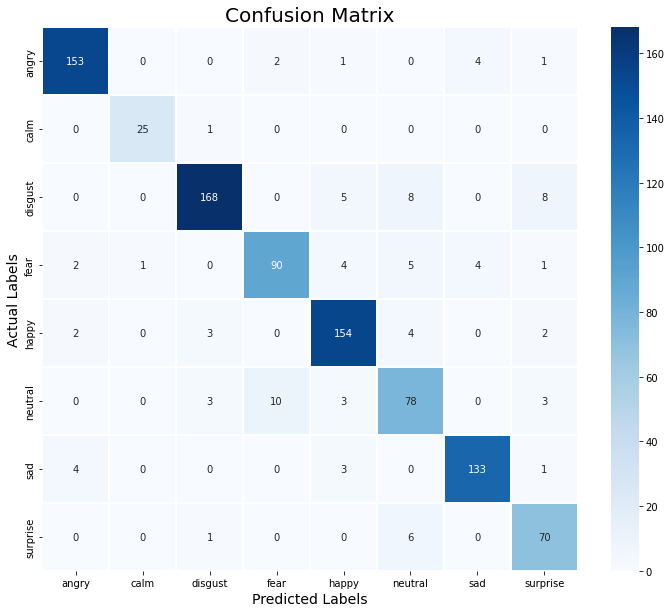

In [39]:
from sklearn.metrics import confusion_matrix
encoder = OneHotEncoder()
data_path.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Y = data_path['Emotions']
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

cm = confusion_matrix(y_actu, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()